# 개요 
* 참여중인 딥러닝 스터디 개인과제 정리
* 원본데이터 : [Kaggle CreditCard Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
  * Privacy보호가 중요한 금융 데이터 익명화를 위해 PCA가 적용되어 있음
  * Class(label)은 1 이상거래, 0은 정상거래를 뜻함
* 데이터 확인 및 전처리
  * Null값 확인
  * Amount(거래액)이 0인 경우는 잡아야 할 거래가 아니라는 관점에서 데이터 제외
  * Standard/MinMax Scaler 적용
  * 데이터가 Imbalance하므로 평가지표를 `F1-score`로 설정(정상 99.8 / 이상 0.2)
* 모델링
  * 수업 때 배운 `딥러닝` 코드로 간단히 구성
  * Keras Tuner를 사용한 모델 구성 후 비교
  * 수업 때 배운 요소들을 지속적으로 하나씩 추가하며 기존모델과 비교
    * Initialization
    * Batch Normalization
    * Learning rate scheduler
    * Early stopping with patience
* 결론
  * `Loss는 지속적인 개선이 되고 있으나 F1score는 계속 비슷한 수치`를 보임
    * `Learning rate Scheduling 적용시에만 약간의 개선`이 있음
    * 과제 발표 후 관련내용 질의 및 `모델개선 예정`
  * 과제 진행 중 생긴 궁금한 점들에 대해서도 추가 질의 예정
    * 이런 모델은 결국 사용하고자 만드는 것인데, PCA로 만든 모델이면 새로운 거래가 생성된 경우 그대로 넣어도 모델이 판별 가능한지
    * epoch 수 대비 적절한 Early stopping patience값이 있는지

# 과제 작성 (Credit Card Fraud Detection)

## 데이터 확인(Kaggle 설명)
* Kaggle 링크 : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
* 컬럼별 정보
  * V1~V28 : may be result of a PCA Dimensionality reduction to protect user identities and sensitive features(v1-v28)
  * Amount : Transaction amount
  * Class : 1 for fraudulent transactions, 0 otherwise

## 데이터 확인 및 전처리

In [ ]:
import pandas as pd
import sqlite3

# Create a connection to the SQLite database
conn = sqlite3.connect('creditcard.db')

# Read the data from the database into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM creditcard", conn)

# Close the connection
conn.close()
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


* **Null값 확인**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

* **Amount가 0인 값 확인**
  * 결제에 대한 Validation 등에 대한 기록으로 추정
  * 이상거래(Class 1)인 데이터도 있긴 하지만, 실질적인 돈의 이동이 없는 것을 이상거래로 잡아야할지에 대한 의문
  * Amount 0인 값은 제외하는 것으로 결정

In [ ]:
df[df['Amount']==0]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
383,282.0,-0.356466,0.725418,1.971749,0.831343,0.369681,-0.107776,0.751610,-0.120166,-0.420675,...,0.020804,0.424312,-0.015989,0.466754,-0.809962,0.657334,-0.043150,-0.046401,0.0,0
514,380.0,-1.299837,0.881817,1.452842,-1.293698,-0.025105,-1.170103,0.861610,-0.193934,0.592001,...,-0.272563,-0.360853,0.223911,0.598930,-0.397705,0.637141,0.234872,0.021379,0.0,0
534,403.0,1.237413,0.512365,0.687746,1.693872,-0.236323,-0.650232,0.118066,-0.230545,-0.808523,...,-0.077543,-0.178220,0.038722,0.471218,0.289249,0.871803,-0.066884,0.012986,0.0,0
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.0,1
575,430.0,-1.860258,-0.629859,0.966570,0.844632,0.759983,-1.481173,-0.509681,0.540722,-0.733623,...,0.268028,0.125515,-0.225029,0.586664,-0.031598,0.570168,-0.043007,-0.223739,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283719,171817.0,-0.750414,0.904175,0.996461,0.427284,1.720336,0.929256,0.794272,0.176719,-1.836261,...,0.050750,0.115532,-0.623995,-0.186896,0.733759,2.558151,-0.188835,0.001654,0.0,0
283782,171870.0,2.083677,-0.065811,-1.442870,0.135416,0.043035,-1.306975,0.335835,-0.371635,0.730560,...,-0.147536,-0.246599,0.194758,-0.082277,0.012887,-0.069278,-0.048995,-0.065482,0.0,0
283949,172027.0,2.132569,-0.057836,-1.724522,-0.030326,0.412146,-0.903088,0.345843,-0.348132,0.722638,...,-0.188739,-0.343876,0.105024,-0.763831,0.117381,-0.027682,-0.047514,-0.071700,0.0,0
284085,172140.0,-2.210521,-1.039425,0.189704,-1.291932,3.742120,-1.665061,3.120388,-2.324089,0.364926,...,-0.286359,1.326003,-0.361764,-0.268117,1.051309,0.334629,-1.930149,-0.899888,0.0,0


In [ ]:
df_filtered1 = df[df['Amount'] != 0].copy()
df_filtered1

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [ ]:
df_filtered1[df_filtered1['Amount']==0]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


* **Label값(이상거래 비중) 확인**
  * Imbalance한 경우, Accuracy는 성능측정에 한계가 있으므로, 다른 지표를 사용
  * `F1-Score` 사용 예정

In [ ]:
df_filtered1["Class"].value_counts(normalize=True)

Class
0    0.998357
1    0.001643
Name: proportion, dtype: float64

* **X와 Y로 나누고, Scaler 적용(StandardScaler, MinMaxScaler)**

In [ ]:
df_x = df_filtered1.drop(['Time', 'Class'], axis=1).copy()
df_y = df_filtered1['Class'].copy()

In [ ]:
df_x.shape, df_y.shape

((282982, 29), (282982,))

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_minmax = MinMaxScaler()
df_x_scaled = scaler_minmax.fit_transform(df_x)

scaler_std = StandardScaler()
df_x_scaled = scaler_std.fit_transform(df_x_scaled)

In [ ]:
df_x_scaled

array([[-0.6947547 , -0.04287463,  1.67720049, ...,  0.33079262,
        -0.06431265,  0.24200481],
       [ 0.60928   ,  0.16247803,  0.11211972, ..., -0.02292114,
         0.0439881 , -0.34378459],
       [-0.6940121 , -0.81075824,  1.17321784, ..., -0.13798659,
        -0.18145722,  1.15515532],
       ...,
       [ 0.98117703, -0.18130206, -2.14391593, ...,  0.01042466,
        -0.08098516, -0.08388116],
       [-0.12269922,  0.32263185,  0.46611873, ...,  0.26940666,
         0.31584664, -0.31464064],
       [-0.27242357, -0.11373381,  0.46666497, ..., -0.0066233 ,
         0.04073321,  0.51063947]])

* **train, test데이터 나누기**

In [ ]:
from sklearn.model_selection import train_test_split

# train + test
x_train, x_test = train_test_split(df_x_scaled, test_size=0.3)
y_train, y_test = train_test_split(df_y, test_size=0.3)

print('Train과 Test로 나누기')
print(x_train.shape, x_test.shape)
print(x_train.shape, y_test.shape)

# train + validation
x_train, x_validate = train_test_split(x_train, test_size=0.3)
y_train, y_validate = train_test_split(y_train, test_size=0.3)

print()
print('Train과 Validation으로 나누기')
print(x_train.shape, x_validate.shape, x_test.shape)
print(y_train.shape, y_validate.shape, y_test.shape)

Train과 Test로 나누기
(198087, 29) (84895, 29)
(198087, 29) (84895,)

Train과 Validation으로 나누기
(138660, 29) (59427, 29) (84895, 29)
(138660,) (59427,) (84895,)


## 모델링

### 모델링 (기초 딥러닝)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 모델링
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((29,1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid') # 이진분류이므로 Sigmoid사용
])

model.compile(optimizer='adam',
              loss='binary_crossentropy', # 0과 1의 이진분류이므로 binary_crossentropy 사용
              metrics=['F1Score'])

# 모델 학습
history = model.fit(x_train, y_train, epochs=10)

# 모델 평가
print('* 모델평가')
loss, f1score = model.evaluate(x_train, y_train, verbose=2)
loss, f1score = model.evaluate(x_test, y_test, verbose=2)

Epoch 1/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 4s 763us/step - F1Score: 0.0037 - loss: 0.0360
Epoch 2/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 3s 776us/step - F1Score: 0.0036 - loss: 0.0140
Epoch 3/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 3s 761us/step - F1Score: 0.0035 - loss: 0.0129
Epoch 4/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 3s 730us/step - F1Score: 0.0033 - loss: 0.0123
Epoch 5/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 3s 718us/step - F1Score: 0.0036 - loss: 0.0131
Epoch 6/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 3s 728us/step - F1Score: 0.0033 - loss: 0.0119
Epoch 7/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 3s 740us/step - F1Score: 0.0036 - loss: 0.0128
Epoch 8/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 3s 730us/step - F1Score: 0.0033 - loss: 0.0118
Epoch 9/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 5s 726us/step - F1Score: 0.0033 - loss: 0.0114
Epoch 10/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 3s 729us/step - F1Score: 0.0035 - loss: 0.0122
* 모델평가
4334/4334 - 2s - 531us/step - F1Score: 0.0034 - loss: 0.0114
2653/2653 - 1s - 511us/step - F1Score: 0.

### 모델링 (Keras tuner[Hyper parameter세팅])
* `Hidden Layer`의 수
* `Neuron`의 수
* `Activation fuction` : ReLU, ELU 중 택1
  * Reaky ReLU도 고려대상에 넣고싶었지만, String이 아닌 별도 함수로 적용해야해서 제외
* `Optimizer` : 같은 조건으로 2개의 Optimizer(Adam, Nadam)로 먼저 돌렸다가 Tuner에게 추천받은 Nadam으로 설정

In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
    model = tf.keras.models.Sequential()

    # Input & Flatten
    model.add(tf.keras.layers.Input((29,1)))
    model.add(tf.keras.layers.Flatten())

    # Hidden Layers
    for i in range(hp.Int('num_layers',min_value=1,max_value=20)):

        # For Dense
        units = hp.Int('units',min_value=5,max_value=150,step=5) # For Neurons
        activation = hp.Choice('activation'+str(i),values=['relu','elu']) # For Activation

        model.add(tf.keras.layers.Dense(units, activation=activation))

        # For Dropout
        dropout_rate = hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

        model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 이진분류이므로 Sigmoid사용
        
    
    optimizer=hp.Choice('optimizer',values=['Nadam'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['F1Score'])
    
    return model

with tf.device('/device:GPU:0'):
    tuner=kt.RandomSearch(build_model,
                        objective=kt.Objective('val_F1Score', direction='max'),# accuracy 미사용
                        overwrite=True,
                        max_trials=9,
                        project_name='randomsearch_model')


    tuner.search(x_train,y_train,epochs=10,validation_data=(x_test,y_test))

Trial 9 Complete [00h 01m 10s]
val_F1Score: 0.0028702165000140667

Best val_F1Score So Far: 0.0028861388564109802
Total elapsed time: 00h 18m 28s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 12,
 'units': 90,
 'activation0': 'relu',
 'dropout0': 0.9,
 'optimizer': 'Nadam',
 'activation1': 'relu',
 'dropout1': 0.1,
 'activation2': 'relu',
 'dropout2': 0.1,
 'activation3': 'relu',
 'dropout3': 0.1,
 'activation4': 'relu',
 'dropout4': 0.1,
 'activation5': 'relu',
 'dropout5': 0.1,
 'activation6': 'relu',
 'dropout6': 0.1,
 'activation7': 'relu',
 'dropout7': 0.1,
 'activation8': 'relu',
 'dropout8': 0.1,
 'activation9': 'relu',
 'dropout9': 0.1,
 'activation10': 'relu',
 'dropout10': 0.1,
 'activation11': 'relu',
 'dropout11': 0.1}

In [ ]:
model_2= tuner.get_best_models(num_models=1)[0]
model_2.summary()

c:\Users\kibok\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 55 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 90)             │         2,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │         8,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 90)             │         8,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 90)             │         8,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 90)             │         8,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 90)             │         8,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 90)             │         8,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 90)             │         8,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 90)             │         8,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 90)             │         8,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 90)             │         8,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 90)             │         8,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 90)             │             

 Total params: 92,881 (362.82 KB)

 Trainable params: 92,881 (362.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 학습
history = model_2.fit(x_train, y_train, epochs=10)

# 모델 평가
print('* 모델평가')
loss, f1score = model_2.evaluate(x_train, y_train, verbose=2)
loss, f1score = model_2.evaluate(x_test, y_test, verbose=2)

Epoch 1/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - F1Score: 0.0031 - loss: 0.0463
Epoch 2/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0034 - loss: 0.0222
Epoch 3/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0031 - loss: 0.0144
Epoch 4/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0032 - loss: 0.0202
Epoch 5/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0034 - loss: 0.0200
Epoch 6/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0034 - loss: 0.0166
Epoch 7/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0036 - loss: 0.0167
Epoch 8/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - F1Score: 0.0032 - loss: 0.0131
Epoch 9/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - F1Score: 0.0033 - loss: 0.0229
Epoch 10/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - F1Score: 0.0032 - loss: 0.0216
* 모델평가
4334/4334 - 4s - 1ms/step - F1Score: 0.0034 - loss: 0.0125
2653/2653 - 2s - 787us/step - F1Score: 0.0029 - loss:

#### F1Score 및 Loss 개선 비교
* 모델평가(기본) <br>
  * 4334/4334 - 2s - 531us/step - F1Score: 0.0034 - loss: 0.0114
  * 2653/2653 - 1s - 511us/step - F1Score: 0.0029 - loss: 0.0123

* 모델평가(Tuner) <br>
  * 4334/4334 - 4s - 860us/step - F1Score: 0.0034 - loss: 0.0175
  * 2653/2653 - 2s - 862us/step - F1Score: 0.0029 - loss: 0.0164

### 모델링 (Keras tuner + Initialization 추가)
  * `HeNormal (Kaiming) 적용`
    * 수업시간에 배운 `Random`/`Xavier`/ `Kaiming/MSRA Initialization for ReLU`에 대해 검색해 봄
      * 미설정시 기본값은 Xavier(GlorotNormal)로 적용된다고 함
      * **Pytorch와 Tensorflow에서의 Initialization 명칭이 다름**
        * HeNormal(Tensorflow) / Kaiming (Pytorch)
        * GlorotNormal(Tensorflow) / XavierNormal (Pytorch)
        * Random Normall(Tensorflow) / Random(Pytorch)
      * Innitialization은 `kernel_initializer(Weight)`뿐 아니라 `bias_initializer(Bias)`도 있음

In [ ]:
def build_model(hp):
    model = tf.keras.models.Sequential()

    # Input & Flatten
    model.add(tf.keras.layers.Input((29,1)))
    model.add(tf.keras.layers.Flatten())

    # Hidden Layers
    for i in range(hp.Int('num_layers',min_value=1,max_value=20)):

        # For Dense
        units = hp.Int('units',min_value=5,max_value=150,step=5) # For Neurons
        activation = hp.Choice('activation'+str(i),values=['relu','elu']) # For Activation

        model.add(tf.keras.layers.Dense(units, activation=activation,
                                        # 기본값은 glorot_uniform(Xavier), He(Kaiming)적용
                                        kernel_initializer=tf.keras.initializers.HeNormal())) 

        # For Dropout
        dropout_rate = hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

        model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 이진분류이므로 Sigmoid사용
        
    
    optimizer=hp.Choice('optimizer',values=['Nadam'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['F1Score'])
    
    return model

with tf.device('/device:GPU:0'):
    tuner=kt.RandomSearch(build_model,
                        objective=kt.Objective('val_F1Score', direction='min'),# accuracy 미사용
                        overwrite=True,
                        max_trials=9,
                        project_name='randomsearch_model_+initialize')


    tuner.search(x_train,y_train,epochs=10,validation_data=(x_test,y_test))

Trial 9 Complete [00h 01m 32s]
val_F1Score: 0.002870013704523444

Best val_F1Score So Far: 0.0
Total elapsed time: 00h 21m 15s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 17,
 'units': 145,
 'activation0': 'elu',
 'dropout0': 0.9,
 'optimizer': 'Nadam',
 'activation1': 'relu',
 'dropout1': 0.9,
 'activation2': 'relu',
 'dropout2': 0.8,
 'activation3': 'elu',
 'dropout3': 0.9,
 'activation4': 'elu',
 'dropout4': 0.6,
 'activation5': 'elu',
 'dropout5': 0.9,
 'activation6': 'relu',
 'dropout6': 0.4,
 'activation7': 'relu',
 'dropout7': 0.2,
 'activation8': 'elu',
 'dropout8': 0.7,
 'activation9': 'relu',
 'dropout9': 0.3,
 'activation10': 'elu',
 'dropout10': 0.4,
 'activation11': 'relu',
 'dropout11': 0.8,
 'activation12': 'elu',
 'dropout12': 0.2,
 'activation13': 'relu',
 'dropout13': 0.1,
 'activation14': 'relu',
 'dropout14': 0.1,
 'activation15': 'relu',
 'dropout15': 0.1,
 'activation16': 'relu',
 'dropout16': 0.1}

In [ ]:
model_3= tuner.get_best_models(num_models=1)[0]
model_3.summary()

c:\Users\kibok\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 75 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 145)            │         4,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 145)            │        21,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 145)            │        21,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 145)            │        21,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 145)            │        21,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 145)            │        21,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 145)            │        21,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 145)            │        21,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 145)            │        21,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 145)            │        21,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 145)            │        21,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 145)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 145)            │        21,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 145)            │             

 Total params: 343,216 (1.31 MB)

 Trainable params: 343,216 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 학습
history = model_3.fit(x_train, y_train, epochs=10)

# 모델 평가
print('* 모델평가')
loss, f1score = model_3.evaluate(x_train, y_train, verbose=2)
loss, f1score = model_3.evaluate(x_test, y_test, verbose=2)

Epoch 1/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - F1Score: 0.0031 - loss: 0.3784
Epoch 2/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - F1Score: 0.0033 - loss: 0.0700
Epoch 3/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - F1Score: 0.0031 - loss: 0.1938
Epoch 4/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - F1Score: 0.0032 - loss: 0.2460
Epoch 5/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - F1Score: 0.0035 - loss: 0.2332
Epoch 6/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - F1Score: 0.0038 - loss: 0.0661
Epoch 7/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - F1Score: 0.0033 - loss: 0.0123
Epoch 8/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - F1Score: 0.0033 - loss: 0.0124
Epoch 9/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - F1Score: 0.0031 - loss: 0.0583
Epoch 10/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - F1Score: 0.0033 - loss: 0.4909
* 모델평가
4334/4334 - 6s - 1ms/step - F1Score: 0.0034 - loss: 0.0124
2653/2653 - 4s - 1ms/step - F1Score: 0.0029 - loss: 0

#### F1Score 및 Loss 개선 비교
* 모델평가(기본) <br>
  * 4334/4334 - 2s - 531us/step - F1Score: 0.0034 - loss: 0.0114
  * 2653/2653 - 1s - 511us/step - F1Score: 0.0029 - loss: 0.0123

* 모델평가(Tuner) <br>
  * 4334/4334 - 4s - 860us/step - F1Score: 0.0034 - loss: 0.0175
  * 2653/2653 - 2s - 862us/step - F1Score: 0.0029 - loss: 0.0164

* 모델평가(Tuner + Kaiming Initialization) <br>
  * 4334/4334 - 6s - 1ms/step - F1Score: 0.0034 - loss: 0.0124
  * 2653/2653 - 4s - 1ms/step - F1Score: 0.0029 - loss: 0.0109

### 모델링 (Keras tuner + Batch Normalization 추가)
  * Activation layer 전에 Batch normalization 적용

In [ ]:
def build_model(hp):
    model = tf.keras.models.Sequential()

    # Input & Flatten
    model.add(tf.keras.layers.Input((29,1)))
    model.add(tf.keras.layers.Flatten())

    # Hidden Layers
    for i in range(hp.Int('num_layers',min_value=1,max_value=20)):

        # For Dense
        units = hp.Int('units',min_value=5,max_value=150,step=5) # For Neurons
        activation = hp.Choice('activation'+str(i),values=['relu','elu']) # For Activation

        model.add(tf.keras.layers.Dense(units, activation=activation,
                                        # 기본값은 glorot_uniform(Xavier), He는 Kaiming
                                        kernel_initializer=tf.keras.initializers.HeNormal())) 
        
        # Add Batch Normalization
        model.add(tf.keras.layers.BatchNormalization()) # Layer통과후 & Activation 전
        
        # For Dropout
        dropout_rate = hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

        model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 이진분류이므로 Sigmoid사용
        
    
    optimizer=hp.Choice('optimizer',values=['Nadam'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['F1Score'])
    
    return model

with tf.device('/device:GPU:0'):
    tuner=kt.RandomSearch(build_model,
                        objective=kt.Objective('val_F1Score', direction='min'),# accuracy 미사용
                        overwrite=True,
                        max_trials=9,
                        project_name='randomsearch_model_+initialize+batchnormalize')


    tuner.search(x_train,y_train,epochs=10,validation_data=(x_test,y_test))

Trial 9 Complete [00h 05m 00s]
val_F1Score: 0.003198833204805851

Best val_F1Score So Far: 0.003198833204805851
Total elapsed time: 00h 25m 05s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 3,
 'units': 5,
 'activation0': 'relu',
 'dropout0': 0.2,
 'optimizer': 'Nadam',
 'activation1': 'relu',
 'dropout1': 0.1,
 'activation2': 'relu',
 'dropout2': 0.1}

In [ ]:
model_4= tuner.get_best_models(num_models=1)[0]
model_4.summary()

c:\Users\kibok\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 31 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5)              │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5)              │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5)              │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276 (1.08 KB)

 Trainable params: 246 (984.00 B)

 Non-trainable params: 30 (120.00 B)

In [ ]:
# 모델 학습
history = model_4.fit(x_train, y_train, epochs=10)

# 모델 평가
print('* 모델평가')
loss, f1score = model_4.evaluate(x_train, y_train, verbose=2)
loss, f1score = model_4.evaluate(x_test, y_test, verbose=2)

Epoch 1/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - F1Score: 0.0038 - loss: 0.0143
Epoch 2/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0030 - loss: 0.0116
Epoch 3/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0033 - loss: 0.0125
Epoch 4/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - F1Score: 0.0034 - loss: 0.0130
Epoch 5/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0034 - loss: 0.0126
Epoch 6/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0035 - loss: 0.0132
Epoch 7/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0034 - loss: 0.0130
Epoch 8/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0036 - loss: 0.0133
Epoch 9/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0029 - loss: 0.0111
Epoch 10/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0035 - loss: 0.0131
* 모델평가
4334/4334 - 3s - 788us/step - F1Score: 0.0034 - loss: 0.0125
2653/2653 - 2s - 757us/step - F1Score: 0.0029 - loss

#### F1Score 및 Loss 개선 비교
* 모델평가(기본) <br>
  * 4334/4334 - 2s - 531us/step - F1Score: 0.0034 - loss: 0.0114
  * 2653/2653 - 1s - 511us/step - F1Score: 0.0029 - loss: 0.0123

* 모델평가(Tuner) <br>
  * 4334/4334 - 4s - 860us/step - F1Score: 0.0034 - loss: 0.0175
  * 2653/2653 - 2s - 862us/step - F1Score: 0.0029 - loss: 0.0164

* 모델평가(Tuner + Kaiming Initialization) <br>
  * 4334/4334 - 6s - 1ms/step - F1Score: 0.0034 - loss: 0.0124
  * 2653/2653 - 4s - 1ms/step - F1Score: 0.0029 - loss: 0.0109

* 모델평가(Tuner + Kaiming Initialization + Batch Normalization) <br>
  * 4334/4334 - 3s - 788us/step - F1Score: 0.0034 - loss: 0.0125
  * 2653/2653 - 2s - 757us/step - F1Score: 0.0029 - loss: 0.0110

### 모델 중간 저장
* 이후 부터는 Learning rate 등의 변경만 있을 예정으로, Tuner를 사용하지 않고 모델을 저장했다가 사용

In [ ]:
model_4 = tuner.get_best_models(num_models=1)[0]
model_4.save('model_4.keras')

### 모델링 (현재 모델에서 Learning rate별 비교 : 0.1, 0.01, 0.05)

#### Learning rate : 0.1
* Loss값이 튀는 상황으로 줄여야 할 것으로 보임

In [ ]:
# 새로운 학습률 설정
new_learning_rate = 0.1

model_4 = keras.models.load_model('model_4.keras')
new_optimizer = tf.keras.optimizers.Nadam(learning_rate=new_learning_rate)
model_4.compile(optimizer=new_optimizer, loss='binary_crossentropy',metrics=['F1Score'])

history = model_4.fit(x_train, y_train, epochs=10)

# 모델 평가
print('* 모델평가')
loss, f1score = model_4.evaluate(x_train, y_train, verbose=2)
loss, f1score = model_4.evaluate(x_test, y_test, verbose=2)

Epoch 1/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - F1Score: 0.0038 - loss: 0.0155
Epoch 2/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0036 - loss: 0.0142
Epoch 3/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - F1Score: 0.0035 - loss: 0.0136
Epoch 4/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - F1Score: 0.0034 - loss: 0.0137
Epoch 5/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0035 - loss: 0.0143
Epoch 6/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - F1Score: 0.0036 - loss: 0.0144
Epoch 7/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - F1Score: 0.0031 - loss: 0.0120
Epoch 8/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0037 - loss: 0.0145
Epoch 9/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - F1Score: 0.0036 - loss: 0.0141
Epoch 10/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - F1Score: 0.0034 - loss: 0.0131
* 모델평가
4334/4334 - 3s - 639us/step - F1Score: 0.0034 - loss: 0.0130
2653/2653 - 2s - 629us/step - F1Score: 0.0032 - loss: 0.0127


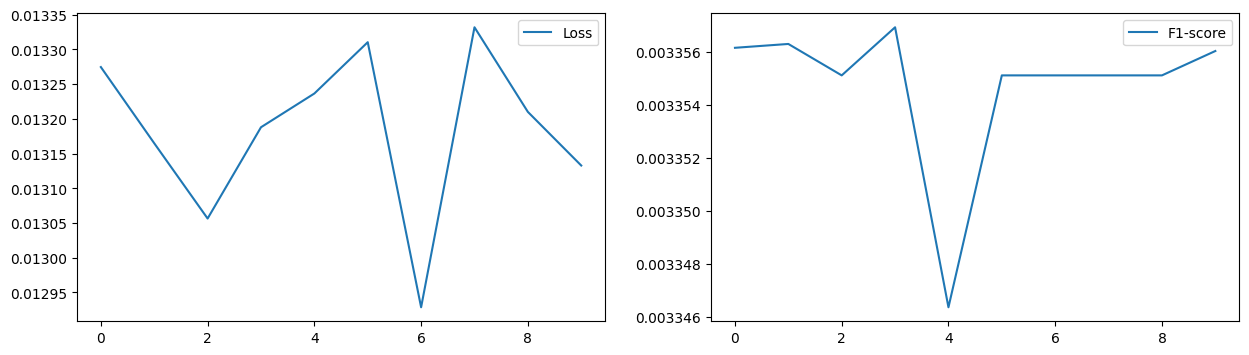

In [ ]:
# Loss 및 F1-Score 시각화
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
ax1.plot(history.history['loss'], label='Loss')
ax2.plot(history.history['F1Score'], label='F1-score')
ax1.legend(), ax2.legend()
plt.show()

#### Learning rate : 0.01
* Loss값이 원만하게 하락

In [ ]:
# 새로운 학습률 설정
new_learning_rate = 0.01

model_4 = keras.models.load_model('model_4.keras')
new_optimizer = tf.keras.optimizers.Nadam(learning_rate=new_learning_rate)
model_4.compile(optimizer=new_optimizer, loss='binary_crossentropy',metrics=['F1Score'])

history = model_4.fit(x_train, y_train, epochs=10)

# 모델 평가
print('* 모델평가')
loss, f1score = model_4.evaluate(x_train, y_train, verbose=2)
loss, f1score = model_4.evaluate(x_test, y_test, verbose=2)

Epoch 1/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - F1Score: 0.0034 - loss: 0.0137
Epoch 2/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0031 - loss: 0.0122
Epoch 3/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0037 - loss: 0.0137
Epoch 4/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0029 - loss: 0.0114
Epoch 5/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0034 - loss: 0.0128
Epoch 6/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0034 - loss: 0.0127
Epoch 7/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0034 - loss: 0.0126
Epoch 8/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0033 - loss: 0.0123
Epoch 9/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0037 - loss: 0.0134
Epoch 10/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0033 - loss: 0.0122
* 모델평가
4334/4334 - 3s - 649us/step - F1Score: 0.0034 - loss: 0.0124
2653/2653 - 2s - 658us/step - F1Score: 0.0032 - loss: 0.0121


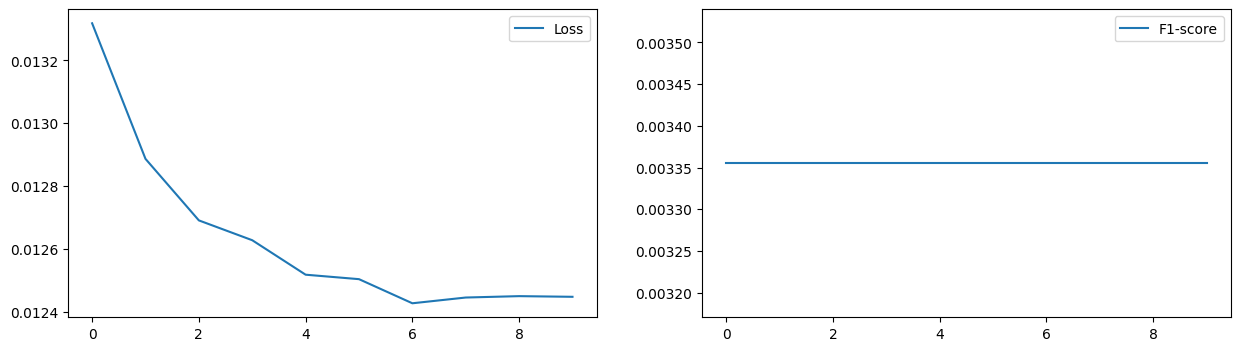

In [ ]:
# Loss 및 F1-Score 시각화
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
ax1.plot(history.history['loss'], label='Loss')
ax2.plot(history.history['F1Score'], label='F1-score')
ax1.legend(), ax2.legend()
plt.show()

#### Learning rate : 0.05
* Loss값이 조금 위아래로 움직임. 
* 향후 현재의 10회가 아닌 1000회 epoch을 돌려볼 것이므로 학습시간을 고려새 0.01이 아닌 0.05로 적용하는 것을 고려

In [ ]:
# 새로운 학습률 설정
new_learning_rate = 0.05

model_4 = keras.models.load_model('model_4.keras')
new_optimizer = tf.keras.optimizers.Nadam(learning_rate=new_learning_rate)
model_4.compile(optimizer=new_optimizer, loss='binary_crossentropy',metrics=['F1Score'])

history = model_4.fit(x_train, y_train, epochs=10)

# 모델 평가
print('* 모델평가')
loss, f1score = model_4.evaluate(x_train, y_train, verbose=2)
loss, f1score = model_4.evaluate(x_test, y_test, verbose=2)

Epoch 1/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - F1Score: 0.0032 - loss: 0.0137
Epoch 2/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - F1Score: 0.0032 - loss: 0.0120
Epoch 3/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - F1Score: 0.0031 - loss: 0.0119
Epoch 4/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0035 - loss: 0.0130
Epoch 5/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0035 - loss: 0.0131
Epoch 6/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0033 - loss: 0.0124
Epoch 7/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0033 - loss: 0.0126
Epoch 8/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0034 - loss: 0.0128
Epoch 9/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0038 - loss: 0.0141
Epoch 10/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0032 - loss: 0.0119
* 모델평가
4334/4334 - 3s - 666us/step - F1Score: 0.0034 - loss: 0.0124
2653/2653 - 2s - 648us/step - F1Score: 0.0032 - loss: 0.0119


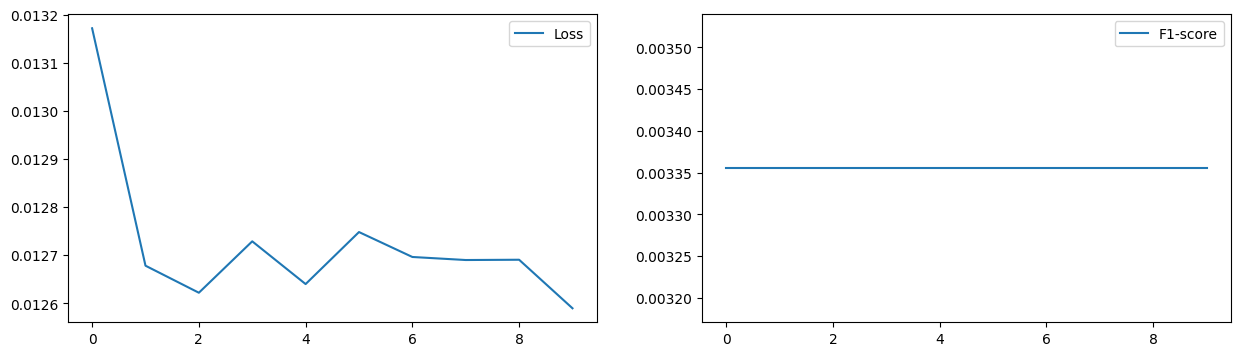

In [ ]:
# Loss 및 F1-Score 시각화
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
ax1.plot(history.history['loss'], label='Loss')
ax2.plot(history.history['F1Score'], label='F1-score')
ax1.legend(), ax2.legend()
plt.show()

### 추가적용 : Learning rate scheduler
* Learning rate 0.05를 적용하기로 했으므로, 동일한 기준인 10 epoch중 loss가 증가했던 구간부터 rate 변경 적용
#### 기본 Learning rate scheduler
* 적용 전과 비교했을 때, Loss가 전반적으로 우하향 하는 추세를 보여줌

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
import keras
import matplotlib.pyplot as plt

In [ ]:
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# 새로운 학습률 설정
new_learning_rate = 0.05

model_4 = keras.models.load_model('model_4.keras')
new_optimizer = tf.keras.optimizers.Nadam(learning_rate=new_learning_rate)
model_4.compile(optimizer=new_optimizer, loss='binary_crossentropy',metrics=['F1Score'])

# 모델 학습
history = model_4.fit(x_train, y_train, epochs=10, 
                      callbacks=[lr_scheduler])

# 모델 평가
print('* 모델평가')
loss, f1score = model_4.evaluate(x_train, y_train, verbose=2)
loss, f1score = model_4.evaluate(x_test, y_test, verbose=2)


Epoch 1: LearningRateScheduler setting learning rate to 0.05000000074505806.
Epoch 1/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - F1Score: 0.0032 - loss: 0.0134 - learning_rate: 0.0500

Epoch 2: LearningRateScheduler setting learning rate to 0.05000000074505806.
Epoch 2/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0035 - loss: 0.0134 - learning_rate: 0.0500

Epoch 3: LearningRateScheduler setting learning rate to 0.05000000074505806.
Epoch 3/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0031 - loss: 0.0120 - learning_rate: 0.0500

Epoch 4: LearningRateScheduler setting learning rate to 0.05000000074505806.
Epoch 4/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - F1Score: 0.0033 - loss: 0.0125 - learning_rate: 0.0500

Epoch 5: LearningRateScheduler setting learning rate to 0.05000000074505806.
Epoch 5/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0031 - loss: 0.0120 - learning_rate: 0.0500

Epoch 6: LearningRateScheduler setting learning rate t

* 적용 전과 비교했을 때, Loss가 전반적으로 우하향 하는 추세를 보여줌

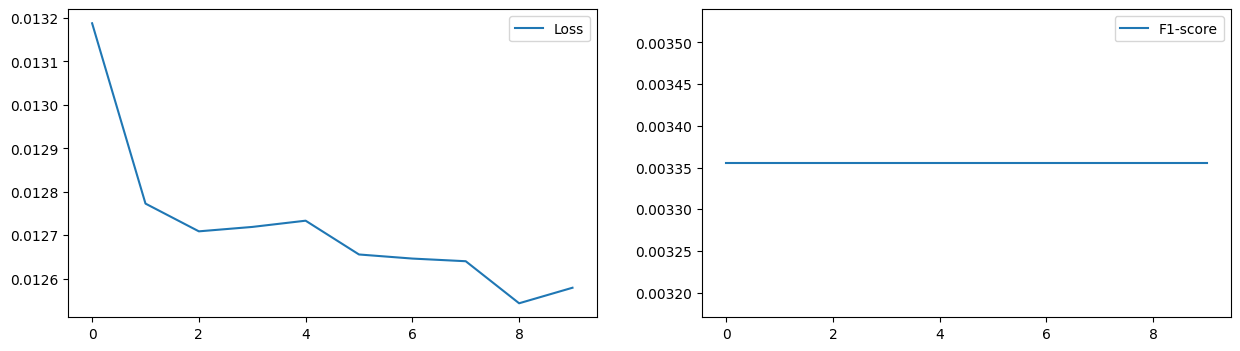

In [ ]:
# Loss 및 F1-Score 시각화
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
ax1.plot(history.history['loss'], label='Loss')
ax2.plot(history.history['F1Score'], label='F1-score')
ax1.legend(), ax2.legend()
plt.show()

#### `Cosine` Learning rate scheduler
* ChatGPT의 도움을 받아 기존의 scheduler코드를 수업 때 배웠던 Cosine decay로 변경
* Cosine decay 적용 전보다 더 부드럽게 우하향하는 추세를 보여줌

In [ ]:
import numpy as np

total_epoch_value = 10

def scheduler(epoch, lr):
    # Compute the cosine decay factor
    cosine_decay = 0.5 * (1 + np.cos(np.pi * epoch / total_epoch_value))
    # Update learning rate
    new_lr = lr * cosine_decay
    return float(new_lr)

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# 새로운 학습률 설정
new_learning_rate = 0.05

model_4 = keras.models.load_model('model_4.keras')
new_optimizer = tf.keras.optimizers.Nadam(learning_rate=new_learning_rate)
model_4.compile(optimizer=new_optimizer, loss='binary_crossentropy',metrics=['F1Score'])

# 모델 학습
history = model_4.fit(x_train, y_train, epochs=total_epoch_value, 
                      callbacks=[lr_scheduler])

# 모델 평가
print('* 모델평가')
loss, f1score = model_4.evaluate(x_train, y_train, verbose=2)
loss, f1score = model_4.evaluate(x_test, y_test, verbose=2)


Epoch 1: LearningRateScheduler setting learning rate to 0.05000000074505806.
Epoch 1/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - F1Score: 0.0036 - loss: 0.0149 - learning_rate: 0.0500

Epoch 2: LearningRateScheduler setting learning rate to 0.048776413634204034.
Epoch 2/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0034 - loss: 0.0130 - learning_rate: 0.0488

Epoch 3: LearningRateScheduler setting learning rate to 0.04411868114727063.
Epoch 3/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0033 - loss: 0.0123 - learning_rate: 0.0441

Epoch 4: LearningRateScheduler setting learning rate to 0.03502549477486741.
Epoch 4/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0035 - loss: 0.0132 - learning_rate: 0.0350

Epoch 5: LearningRateScheduler setting learning rate to 0.022924484773646628.
Epoch 5/10
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - F1Score: 0.0035 - loss: 0.0129 - learning_rate: 0.0229

Epoch 6: LearningRateScheduler setting learning rate

* Cosine decay 적용 전보다 더 부드럽게 우하향하는 추세를 보여줌

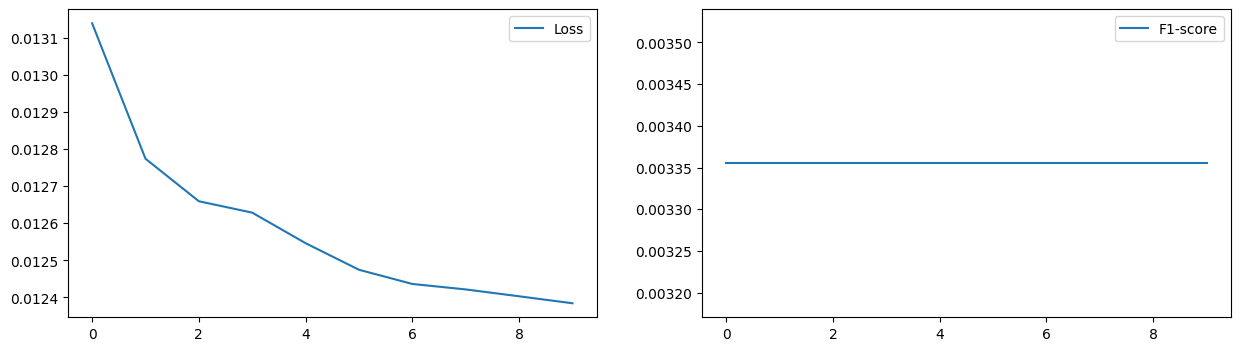

In [ ]:
# Loss 및 F1-Score 시각화
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
ax1.plot(history.history['loss'], label='Loss')
ax2.plot(history.history['F1Score'], label='F1-score')
ax1.legend(), ax2.legend()
plt.show()

#### F1Score 및 Loss 개선 비교
* 모델평가(기본) <br>
  * 4334/4334 - 2s - 531us/step - F1Score: 0.0034 - loss: 0.0114
  * 2653/2653 - 1s - 511us/step - F1Score: 0.0029 - loss: 0.0123

* 모델평가(Tuner) <br>
  * 4334/4334 - 4s - 860us/step - F1Score: 0.0034 - loss: 0.0175
  * 2653/2653 - 2s - 862us/step - F1Score: 0.0029 - loss: 0.0164

* 모델평가(Tuner + Kaiming Initialization) <br>
  * 4334/4334 - 6s - 1ms/step - F1Score: 0.0034 - loss: 0.0124
  * 2653/2653 - 4s - 1ms/step - F1Score: 0.0029 - loss: 0.0109

* 모델평가(Tuner + Kaiming Initialization + Batch Normalization) <br>
  * 4334/4334 - 3s - 788us/step - F1Score: 0.0034 - loss: 0.0125
  * 2653/2653 - 2s - 757us/step - F1Score: 0.0029 - loss: 0.0110

* 모델평가(Tuner + Kaiming Initialization + Batch Normalization + Learning rate Scheduling) <br>
  * 4334/4334 - 3s - 640us/step - F1Score: 0.0034 - loss: 0.0124
  * 2653/2653 - 2s - 670us/step - F1Score: 0.0032 - loss: 0.0119

### 추가적용 : EarlyStopping with patience
  * epoch 1000회로 세팅
  * patience 200으로 세팅

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

total_epoch_value = 1000

def scheduler(epoch, lr):
    # Compute the cosine decay factor
    cosine_decay = 0.5 * (1 + np.cos(np.pi * epoch / total_epoch_value))
    # Update learning rate
    new_lr = lr * cosine_decay
    return float(new_lr)


with tf.device('/device:GPU:0'):
    lr_scheduler = LearningRateScheduler(scheduler, verbose=1)
    es = EarlyStopping(monitor='F1Score', mode='max', verbose=1, patience=200)

    # 새로운 학습률 설정
    new_learning_rate = 0.05

    model_4 = keras.models.load_model('model_4.keras')
    new_optimizer = tf.keras.optimizers.Nadam(learning_rate=new_learning_rate)
    model_4.compile(optimizer=new_optimizer, loss='binary_crossentropy',metrics=['F1Score'])

    # 모델 학습
    history = model_4.fit(x_train, y_train, epochs=total_epoch_value, 
                        callbacks=[lr_scheduler, es],
                        validation_data=(x_test,y_test))

# 모델 평가
print('* 모델평가')
loss, f1score = model_4.evaluate(x_train, y_train, verbose=2)
loss, f1score = model_4.evaluate(x_test, y_test, verbose=2)


Epoch 1: LearningRateScheduler setting learning rate to 0.05000000074505806.
Epoch 1/1000
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - F1Score: 0.0031 - loss: 0.0129 - val_F1Score: 0.0032 - val_loss: 0.0119 - learning_rate: 0.0500

Epoch 2: LearningRateScheduler setting learning rate to 0.049999877375102676.
Epoch 2/1000
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - F1Score: 0.0032 - loss: 0.0122 - val_F1Score: 0.0032 - val_loss: 0.0119 - learning_rate: 0.0500

Epoch 3: LearningRateScheduler setting learning rate to 0.04999938433308759.
Epoch 3/1000
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - F1Score: 0.0033 - loss: 0.0126 - val_F1Score: 0.0032 - val_loss: 0.0121 - learning_rate: 0.0500

Epoch 4: LearningRateScheduler setting learning rate to 0.04999827576351572.
Epoch 4/1000
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - F1Score: 0.0038 - loss: 0.0142 - val_F1Score: 0.0032 - val_loss: 0.0126 - learning_rate: 0.0500

Epoch 5: LearningRateScheduler setting learning rate to 0.04999630210

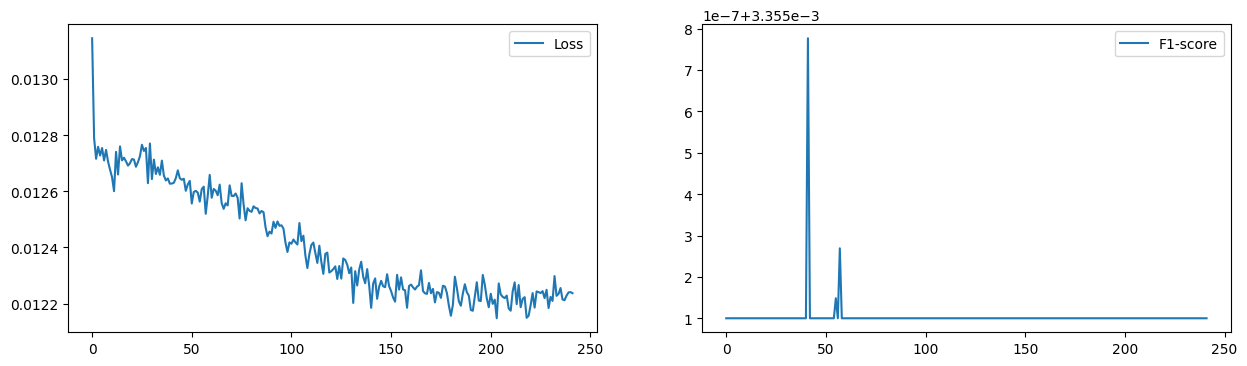

In [ ]:
# Loss 및 F1-Score 시각화
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
ax1.plot(history.history['loss'], label='Loss')
ax2.plot(history.history['F1Score'], label='F1-score')
ax1.legend(), ax2.legend()
plt.show()

#### F1Score 및 Loss 개선 비교
* 모델평가(기본) <br>
  * 4334/4334 - 2s - 531us/step - F1Score: 0.0034 - loss: 0.0114
  * 2653/2653 - 1s - 511us/step - F1Score: 0.0029 - loss: 0.0123

* 모델평가(Tuner) <br>
  * 4334/4334 - 4s - 860us/step - F1Score: 0.0034 - loss: 0.0175
  * 2653/2653 - 2s - 862us/step - F1Score: 0.0029 - loss: 0.0164

* 모델평가(Tuner + Kaiming Initialization) <br>
  * 4334/4334 - 6s - 1ms/step - F1Score: 0.0034 - loss: 0.0124
  * 2653/2653 - 4s - 1ms/step - F1Score: 0.0029 - loss: 0.0109

* 모델평가(Tuner + Kaiming Initialization + Batch Normalization) <br>
  * 4334/4334 - 3s - 788us/step - F1Score: 0.0034 - loss: 0.0125
  * 2653/2653 - 2s - 757us/step - F1Score: 0.0029 - loss: 0.0110

* 모델평가(Tuner + Kaiming Initialization + Batch Normalization + Learning rate Scheduling) <br>
  * 4334/4334 - 3s - 640us/step - F1Score: 0.0034 - loss: 0.0124
  * 2653/2653 - 2s - 670us/step - F1Score: 0.0032 - loss: 0.0119

* 모델평가(Tuner + Kaiming Initialization + Batch Normalization + Learning rate Scheduling + Early Stopping) <br>
  * 4334/4334 - 3s - 594us/step - F1Score: 0.0034 - loss: 0.0121
  * 2653/2653 - 2s - 584us/step - F1Score: 0.0032 - loss: 0.0121

### 결론
* Loss는 지속적인 개선이 되고 있으나 F1score는 계속 비슷한 수치를 보임
  * Learning rate Scheduling 적용시에만 약간의 개선이 있음
* 과제 발표 후 관련 내용 질의 및 개선 예정

* 과제 진행 중 생긴 궁금한 점들에 대해서도 추가 질의 예정
  * 이런 모델은 결국 사용하고자 만드는 것인데, PCA로 만든 모델이면 새로운 거래가 생성된 경우 그대로 넣어도 모델이 판별 가능한지
  * epoch 수 대비 적절한 Early stopping patience값이 있는지